## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ['KMP_DUPLICATE_LIB_OK']='True'


Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 10 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [10]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.3,0.5]
redice_lr_patient = [5,15,25]

In [11]:
import itertools
from keras.callbacks import ReduceLROnPlateau

results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """

    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.30, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_43 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_44 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalizatio

50000/50000 [==============================] - 11s 210us/step - loss: 1.4021 - acc: 0.5113 - val_loss: 1.5297 - val_acc: 0.4608
Epoch 8/10
50000/50000 [==============================] - 10s 210us/step - loss: 1.3680 - acc: 0.5232 - val_loss: 1.5170 - val_acc: 0.4691
Epoch 9/10
50000/50000 [==============================] - 10s 206us/step - loss: 1.3350 - acc: 0.5348 - val_loss: 1.5058 - val_acc: 0.4716
Epoch 10/10
50000/50000 [==============================] - 11s 221us/step - loss: 1.3049 - acc: 0.5453 - val_loss: 1.4996 - val_acc: 0.4764
Numbers of exp: 3, reduce_factor: 0.50, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________


50000/50000 [==============================] - 11s 222us/step - loss: 1.6124 - acc: 0.4349 - val_loss: 1.6803 - val_acc: 0.4139
Epoch 4/10
50000/50000 [==============================] - 12s 243us/step - loss: 1.5361 - acc: 0.4628 - val_loss: 1.6186 - val_acc: 0.4334
Epoch 5/10
50000/50000 [==============================] - 11s 216us/step - loss: 1.4814 - acc: 0.4815 - val_loss: 1.6016 - val_acc: 0.4377
Epoch 6/10
50000/50000 [==============================] - 11s 220us/step - loss: 1.4366 - acc: 0.4984 - val_loss: 1.5639 - val_acc: 0.4540
Epoch 7/10
50000/50000 [==============================] - 11s 224us/step - loss: 1.3962 - acc: 0.5142 - val_loss: 1.5645 - val_acc: 0.4503
Epoch 8/10
50000/50000 [==============================] - 12s 232us/step - loss: 1.3628 - acc: 0.5234 - val_loss: 1.5198 - val_acc: 0.4703
Epoch 9/10
50000/50000 [==============================] - 11s 210us/step - loss: 1.3307 - acc: 0.5367 - val_loss: 1.5081 - val_acc: 0.4732
Epoch 10/10
50000/50000 [=============

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 20s 404us/step - loss: 1.8094 - acc: 0.3620 - val_loss: 1.8465 - val_acc: 0.3692
Epoch 2/10
50000/50000 [==============================] - 14s 283us/step - loss: 1.5581 - acc: 0.4442 - val_loss: 1.6786 - val_acc: 0.4025
Epoch 3/10
50000/50000 [==============================] - 13s 258us/step - loss: 1.4695 - acc: 0.4765 - val_loss: 1.6148 - val_acc: 0.4278
Epoch 4/10
50000/50000 [==============================] - 14s 279us/step - loss: 1.4000 - acc: 0.4987 - val_loss: 1.5038 - val_acc: 0.4710
Epoch 5/10
50000/50000 [==============================] - 14s 289us/step - loss: 1.3431 - acc: 0.5223 - val_loss: 1.5368 - val_acc: 0.4492
Epoch 6/10
50000/50000 [==============================] - 15s 303us/step - loss: 1.2993 - acc: 0.5393 - val_loss: 1.7738 - val_acc: 0.3766
Epoch 7/10
50000/50000 [==============================] - 13s 264us/step - loss: 1.2496 - acc: 0.5554 - val_loss: 1.

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 20s 394us/step - loss: 1.8170 - acc: 0.3632 - val_loss: 1.8420 - val_acc: 0.3818
Epoch 2/10
50000/50000 [==============================] - 13s 259us/step - loss: 1.5735 - acc: 0.4397 - val_loss: 2.0786 - val_acc: 0.3240
Epoch 3/10
50000/50000 [==============================] - 15s 308us/step - loss: 1.4873 - acc: 0.4733 - val_loss: 1.5583 - val_acc: 0.4450
Epoch 4/10
50000/50000 [==============================] - 14s 272us/step - loss: 1.4137 - acc: 0.4974 - val_loss: 1.6623 - val_acc: 0.4113
Epoch 5/10
50000/50000 [==============================] - 13s 268us/step - loss: 1.3635 - acc: 0.5135 - val_loss: 1.5807 - val_acc: 0.4403
Epoch 6/10
50000/50000 [==============================] - 19s 377us/step - loss: 1.3126 - acc: 0.5323 - val_loss: 1.5726 - val_acc: 0.4358
Epoch 7/10
50000/50000 [==============================] - 18s 355us/step - loss: 1.2677 - acc: 0.5488 - val_loss: 1.

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 23s 468us/step - loss: 1.8095 - acc: 0.3791 - val_loss: 2.6429 - val_acc: 0.2528
Epoch 2/10
50000/50000 [==============================] - 15s 296us/step - loss: 1.5288 - acc: 0.4646 - val_loss: 1.9555 - val_acc: 0.3456
Epoch 3/10
50000/50000 [==============================] - 14s 288us/step - loss: 1.4240 - acc: 0.5003 - val_loss: 1.9678 - val_acc: 0.3561
Epoch 4/10
50000/50000 [==============================] - 15s 306us/step - loss: 1.3571 - acc: 0.5246 - val_loss: 2.1452 - val_acc: 0.3203
Epoch 5/10
50000/50000 [==============================] - 16s 324us/step - loss: 1.2895 - acc: 0.5520 - val_loss: 2.2363 - val_acc: 0.3171
Epoch 6/10
50000/50000 [==============================] - 19s 385us/step - loss: 1.2413 - acc: 0.5658 - val_loss: 1.7809 - val_acc: 0.3991
Epoch 7/10
50000/50000 [==============================] - 16s 330us/step - loss: 1.1988 - acc: 0.5817 - val_loss: 2.

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 24s 489us/step - loss: 1.7990 - acc: 0.3797 - val_loss: 2.5155 - val_acc: 0.2731
Epoch 2/10
50000/50000 [==============================] - 14s 280us/step - loss: 1.5189 - acc: 0.4678 - val_loss: 2.5352 - val_acc: 0.3157
Epoch 3/10
50000/50000 [==============================] - 14s 273us/step - loss: 1.4119 - acc: 0.5057 - val_loss: 2.3591 - val_acc: 0.2812
Epoch 4/10
50000/50000 [==============================] - 15s 303us/step - loss: 1.3451 - acc: 0.5304 - val_loss: 2.2230 - val_acc: 0.3046
Epoch 5/10
50000/50000 [==============================] - 14s 272us/step - loss: 1.2845 - acc: 0.5521 - val_loss: 2.5747 - val_acc: 0.2914
Epoch 6/10
50000/50000 [==============================] - 20s 400us/step - loss: 1.2307 - acc: 0.5694 - val_loss: 2.1000 - val_acc: 0.3443
Epoch 7/10
50000/50000 [==============================] - 15s 301us/step - loss: 1.1874 - acc: 0.5835 - val_loss: 1.

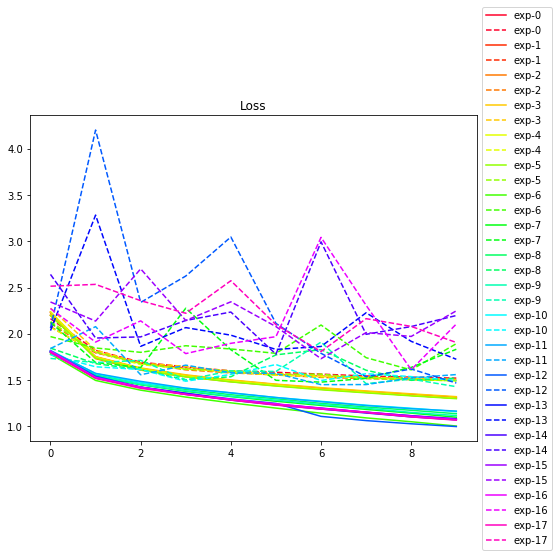

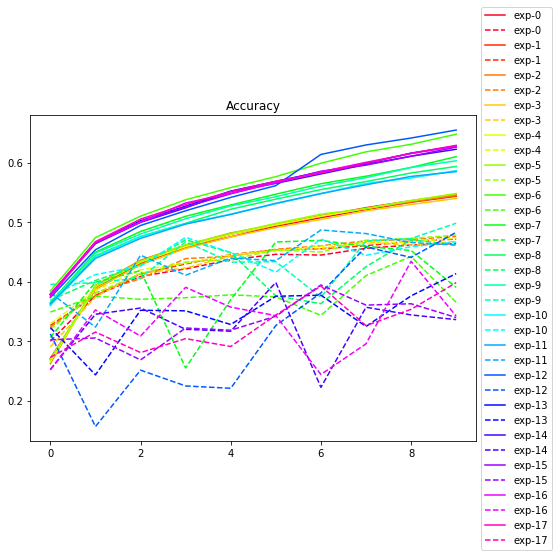

In [12]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()